In [ ]:
# Instalar e importar librerías necesarias
# No es necesario instalar librerías específicas en Python como en R
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

In [ ]:
###########################
# 1. Preparacion de datos #
###########################

# Al poner header= None se crea la primera fila con los nombres de las columnas V1, V2, ...
vote_data = pd.read_csv("house-votes-84.data", header=None, names=["NAME","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16"], na_values="?")

# Observamos el formato del dataset
print(vote_data.head())
print(vote_data.tail())

# Eliminamos los NaN por datos vacíos
vote_data = vote_data.dropna()

# Hacemos que la columna NAME sea factor (variable categórica, con valores democrat o republican)
vote_data["NAME"] = vote_data["NAME"].astype("category")

# Veamos cuántas instancias tenemos de cada clase
print(vote_data["NAME"].value_counts(normalize=True))

         NAME   V1 V2 V3   V4   V5 V6 V7 V8 V9 V10  V11  V12 V13 V14 V15  V16
0  republican    n  y  n    y    y  y  n  n  n   y  NaN    y   y   y   n    y
1  republican    n  y  n    y    y  y  n  n  n   n    n    y   y   y   n  NaN
2    democrat  NaN  y  y  NaN    y  y  n  n  n   n    y    n   y   y   n    n
3    democrat    n  y  y    n  NaN  y  n  n  n   n    y    n   y   n   n    y
4    democrat    y  y  y    n    y  y  n  n  n   n    y  NaN   y   y   y    y
           NAME V1   V2 V3 V4 V5 V6   V7   V8   V9  V10 V11 V12 V13 V14  V15  \
430  republican  n    n  y  y  y  y    n    n    y    y   n   y   y   y    n   
431    democrat  n    n  y  n  n  n    y    y    y    y   n   n   n   n    n   
432  republican  n  NaN  n  y  y  y    n    n    n    n   y   y   y   y    n   
433  republican  n    n  n  y  y  y  NaN  NaN  NaN  NaN   n   y   y   y    n   
434  republican  n    y  n  y  y  y    n    n    n    y   n   y   y   y  NaN   

    V16  
430   y  
431   y  
432   y  
433   y  
4

In [ ]:
##############################################
# 2. Creacion de datos de entrenamiento/test #
##############################################

vote_raw_train, vote_raw_test = train_test_split(vote_data, test_size=65, random_state=42, stratify=vote_data["NAME"])

# Observamos que se mantienen las proporciones
print(vote_raw_train["NAME"].value_counts(normalize=True))
print(vote_raw_test["NAME"].value_counts(normalize=True))


democrat      0.532934
republican    0.467066
Name: NAME, dtype: float64
democrat      0.538462
republican    0.461538
Name: NAME, dtype: float64


In [ ]:
##########################################
# 3. Creacion de features para el modelo #
##########################################

# Convertir las variables categóricas "y" y "n" en valores numéricos
label_encoder = LabelEncoder()
for col in vote_raw_train.columns[1:]:
    vote_raw_train[col] = label_encoder.fit_transform(vote_raw_train[col])
    vote_raw_test[col] = label_encoder.transform(vote_raw_test[col])


# Vote_raw_train y vote_raw_test son data frames de variables categóricas.
# Ambos son una estructura que puede ser utilizada como argumento por el clasificador NB
# Entrenamos un clasificador NB.
# El modelo utiliza la presencia "yes" o ausencia "no" de uno de los 16 restantes atributos
# para estimar la probabilidad de que un votante sea demócrata o republicano.
# alpha=1 para los datos desconocidos
vote_classifier = MultinomialNB(alpha=1)
vote_classifier.fit(vote_raw_train.iloc[:, 1:], vote_raw_train["NAME"])

# Predecimos la clase más probable
vote_test_pred = vote_classifier.predict(vote_raw_test.iloc[:, 1:])

In [ ]:
# Matriz de confusión
conf_matrix = confusion_matrix(vote_raw_test["NAME"], vote_test_pred)
print(conf_matrix)
print(conf_matrix / conf_matrix.sum(axis=1)[:, None])

[[28  7]
 [ 1 29]]
[[0.8        0.2       ]
 [0.03333333 0.96666667]]


In [ ]:
# Predicciones donde se ha equivocado el modelo
misclassifications = vote_raw_test[vote_raw_test["NAME"] != vote_test_pred]
print(misclassifications)

           NAME  V1  V2  V3  V4  V5  V6  V7  V8  V9  V10  V11  V12  V13  V14  \
385    democrat   1   1   0   0   1   1   0   0   0    0    1    1    1    1   
365    democrat   0   1   0   0   1   1   0   0   0    1    1    0    1    1   
406    democrat   1   0   1   0   1   1   0   0   1    1    0    0    1    1   
78     democrat   1   1   1   0   1   1   0   0   0    1    1    0    1    1   
85     democrat   0   0   1   0   1   1   0   0   0    1    1    1    1    1   
100    democrat   1   0   0   0   1   1   0   0   0    0    1    1    0    1   
375    democrat   0   1   0   1   1   1   0   0   0    0    1    1    0    1   
176  republican   0   0   1   1   0   0   1   1   1    1    0    0    0    1   

     V15  V16  
385    1    0  
365    0    0  
406    0    1  
78     0    1  
85     0    1  
100    0    1  
375    0    0  
176    1    1  


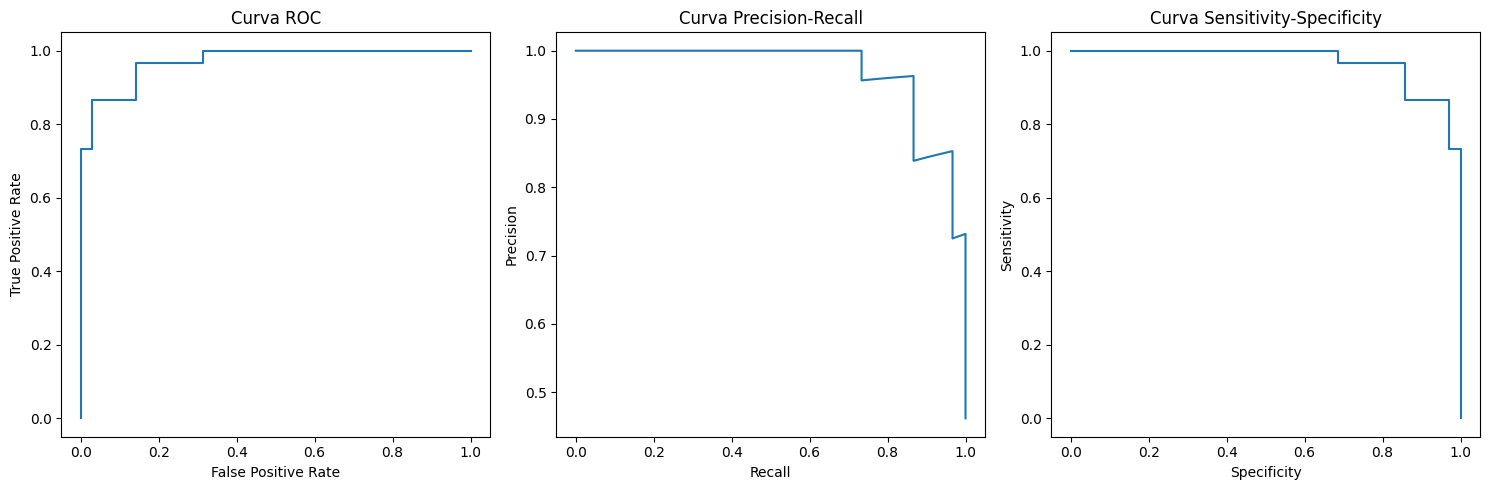

In [ ]:
# Predecimos con probabilidades
vote_test_pred_proba = vote_classifier.predict_proba(vote_raw_test.iloc[:, 1:])

# Crear subgráficos
plt.figure(figsize=(15, 5))

# Subplot 1: Curva ROC
plt.subplot(1, 3, 1)
fpr, tpr, _ = roc_curve((vote_raw_test["NAME"] == "republican").astype(int), vote_test_pred_proba[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')

# Subplot 2: Curva Precision-Recall
plt.subplot(1, 3, 2)
precision, recall, _ = precision_recall_curve((vote_raw_test["NAME"] == "republican").astype(int), vote_test_pred_proba[:, 1])
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')

# Subplot 3: Curva Sensitivity-Specificity
plt.subplot(1, 3, 3)
sensitivity = tpr
specificity = 1 - fpr
plt.plot(specificity, sensitivity)
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Curva Sensitivity-Specificity')

# Mostrar los subgráficos
plt.tight_layout()
plt.show()

In [ ]:
# AUC
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9714285714285714
